In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.dynamics import Dynamics
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples

In [3]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

In [4]:
x_dim = 2
mu = np.zeros(2,)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])

distribution = Gaussian(mu, cov)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network)

9.999999999999705 float64
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


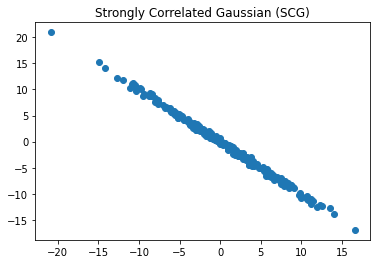

In [5]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [6]:

x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [7]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)
graph = tf.get_default_graph()

The training loop described in Algorithm $1$.

In [8]:
n_steps = 5000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print("Step: {} / {}, Loss: {}, Acceptance sample: {}, LR: {}".format(t, n_steps, loss_, np.mean(px_), lr_))

Step: 0 / 5000, Loss: -82.97789764404297, Acceptance sample: 0.8837062120437622, LR: 0.0010000000474974513
Step: 100 / 5000, Loss: -187.12806701660156, Acceptance sample: 0.785759449005127, LR: 0.0010000000474974513
Step: 200 / 5000, Loss: -577.3759765625, Acceptance sample: 0.581989586353302, LR: 0.0010000000474974513
Step: 300 / 5000, Loss: -4376.876953125, Acceptance sample: 0.4185389578342438, LR: 0.0010000000474974513
Step: 400 / 5000, Loss: -4661.296875, Acceptance sample: 0.3646477460861206, LR: 0.0010000000474974513
Step: 500 / 5000, Loss: -6446.947265625, Acceptance sample: 0.4028394818305969, LR: 0.0010000000474974513
Step: 600 / 5000, Loss: -8722.525390625, Acceptance sample: 0.41530007123947144, LR: 0.0010000000474974513
Step: 700 / 5000, Loss: -7047.8154296875, Acceptance sample: 0.3582097291946411, LR: 0.0010000000474974513
Step: 800 / 5000, Loss: -6040.0263671875, Acceptance sample: 0.37882328033447266, LR: 0.0010000000474974513
Step: 900 / 5000, Loss: -9253.76171875, Ac

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [9]:
graph = tf.get_default_graph()
samples = distribution.get_samples(n=n_samples)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [10]:
L2HMC_samples = np.array(final_samples)
global graph
with graph.as_default():
    HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)
    HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), sess, steps=2000, samples=samples)
    HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [11]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

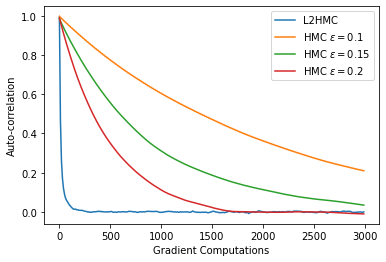

In [12]:
xaxis = 10 * np.arange(300)
plt.plot(xaxis, L2HMC[:300], label='L2HMC')
plt.plot(xaxis, HMC1[:300], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:300], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:300], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [13]:
print("ESS L2HMC: {}.2e -- ESS HMC: {}.2e -- Ratio: {}".format(ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 0.2792500951892557.2e -- ESS HMC: 0.005475897675713488.2e -- Ratio: 50.996222304842554


We can visualize a single chain of L2HMC for $50$ time steps.

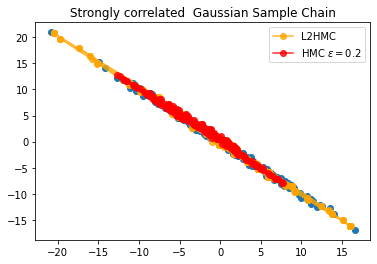

In [14]:
plt.scatter(S[:, 0], S[:, 1])
plt.plot(L2HMC_samples[:200, 1, 0], L2HMC_samples[:200, 1, 1], color='orange', marker='o', alpha=0.8, label = 'L2HMC')
plt.plot(HMC_samples_3[:200, 1, 0], HMC_samples_3[:200, 1, 1], color='red', marker='o', alpha=0.8, label = 'HMC $\epsilon=0.2$')
plt.title('Strongly correlated  Gaussian Sample Chain')
plt.legend()
plt.show()